In [75]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from bagpy import bagreader

In [76]:
# Import data
#bag_filename = "data/_202211301120.51.bag"
bag_filename = "data/_202211301118.14.bag"
#bag_filename = "data/_202211301115.18.bag"

bag = bagreader(bag_filename)

[INFO]  Data folder data/_202211301118.14 already exists. Not creating.


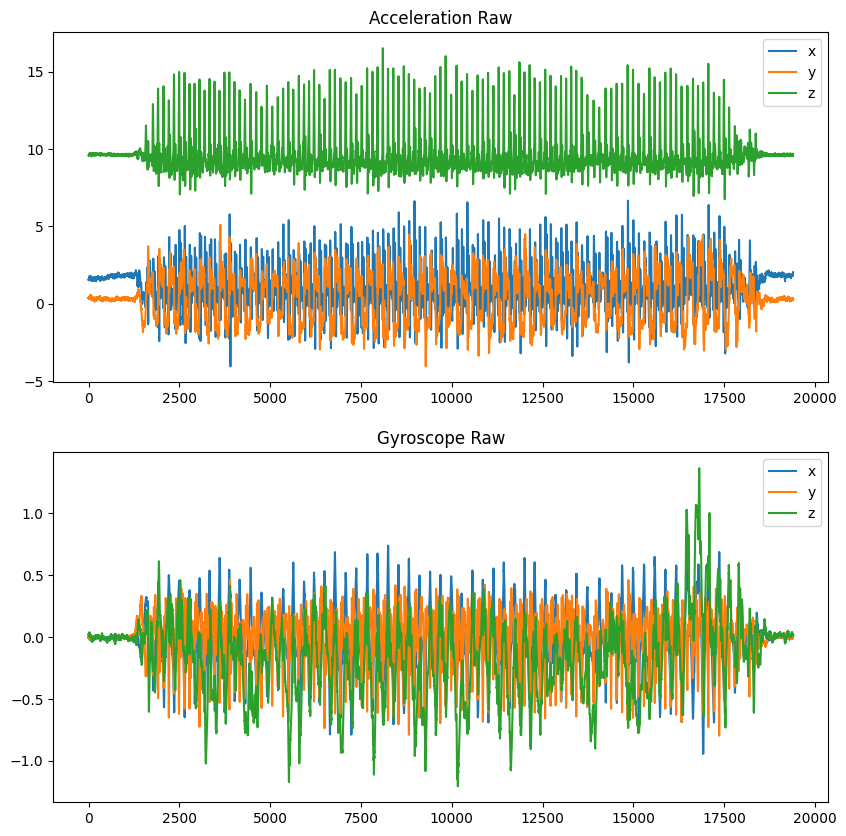

In [77]:
# Extract data
accel_df = pd.read_csv(bag.message_by_topic('/imu/acceleration'))[1:]
gyro_df = pd.read_csv(bag.message_by_topic('/imu/angular_velocity'))[1:]
timesteps = (accel_df['header.stamp.secs'].diff(1) + accel_df['header.stamp.nsecs'].diff(1) / 1e9).to_numpy()


# averaging_window = 20



# vec_accel_raw = accel_df[['vector.x', 'vector.y', 'vector.z']].rolling(averaging_window).mean().to_numpy()
# vec_gyro_raw = gyro_df[['vector.x', 'vector.y', 'vector.z']].rolling(averaging_window).mean().to_numpy()

vec_accel_raw = accel_df[['vector.x', 'vector.y', 'vector.z']].to_numpy()
vec_gyro_raw = gyro_df[['vector.x', 'vector.y', 'vector.z']].to_numpy()

# Plot acceleration and gyroscope data
plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(vec_accel_raw)
plt.title('Acceleration Raw')
plt.legend(['x', 'y', 'z'])
plt.subplot(2,1,2)
plt.plot(vec_gyro_raw)
plt.title('Gyroscope Raw')
plt.legend(['x', 'y', 'z'])
plt.show()



In [78]:
# Do: calibration

# Set z axis of accelerometer to 0
vec_accel_raw[:,2] = 0


vec_accel = vec_accel_raw
vec_gyro = vec_gyro_raw

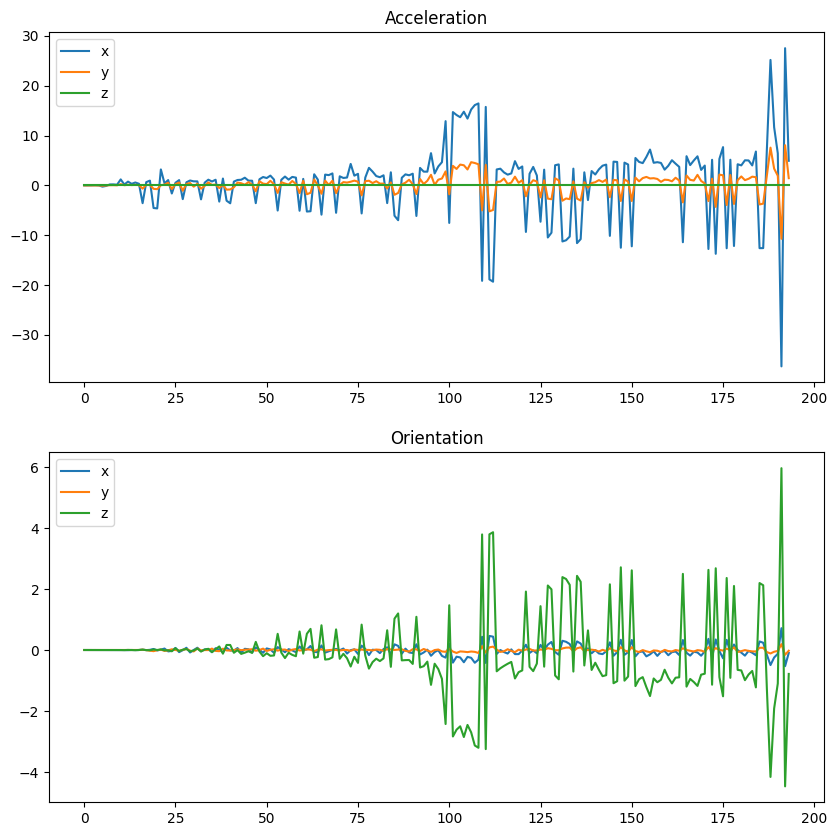

In [79]:
# Get velocity and orientation
vec_velocity = np.cumsum(vec_accel, axis=0) * timesteps[:, np.newaxis]
vec_orientation = np.cumsum(vec_gyro, axis=0) * timesteps[:, np.newaxis]



vec_orientation_filtered = []
vec_velocity_filtered = []


# Try high-pass filtering the data
coefficients = signal.firwin(1001, 2, fs=1000, pass_zero=False)


x_filtered = signal.lfilter(coefficients, 1, vec_velocity[1:,0])
y_filtered = signal.lfilter(coefficients, 1, vec_velocity[1:,1])
z_filtered = signal.lfilter(coefficients, 1, vec_velocity[1:,2])

vec_velocity_filtered = np.array(list(zip(x_filtered, y_filtered, z_filtered)))

x_filtered = signal.lfilter(coefficients, 1, vec_orientation[1:,0])
y_filtered = signal.lfilter(coefficients, 1, vec_orientation[1:,1])
z_filtered = signal.lfilter(coefficients, 1, vec_orientation[1:,2])

vec_orientation_filtered = np.array(list(zip(x_filtered, y_filtered, z_filtered)))

# for p in range(len(vec_velocity)):
#     x, y, z = vec_velocity[p]

#     x_filtered = signal.filtfilt(b, a, x)
#     y_filtered = signal.filtfilt(b, a, y)
#     z_filtered = signal.filtfilt(b, a, z)
#     vec_velocity_filtered.append([x_filtered, y_filtered, z_filtered])  

#     x, y, z = vec_orientation[p]
#     x_filtered = signal.filtfilt(b, a, x)
#     y_filtered = signal.filtfilt(b, a, y)
#     z_filtered = signal.filtfilt(b, a, z)
#     vec_orientation_filtered.append([x_filtered, y_filtered, z_filtered])  



plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(vec_velocity_filtered[::100])
plt.legend(['x', 'y', 'z'])
plt.title('Acceleration')
plt.subplot(2,1,2)
plt.plot(vec_orientation_filtered[::100])
plt.legend(['x', 'y', 'z'])
plt.title('Orientation')
plt.show()

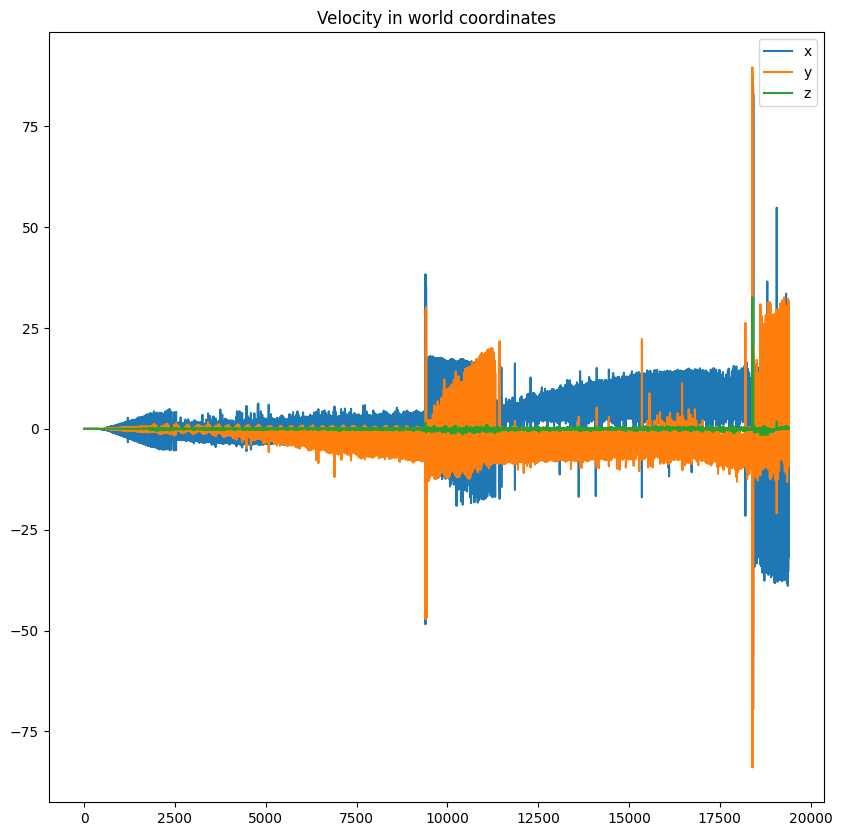

In [80]:
vec_velocity = vec_velocity_filtered
vec_orientation = vec_orientation_filtered

# Apply transformation from body coordinates to world coordinates for each timestep
velocity_world = []

for i in range(len(vec_velocity)):
    # Calculate rotation matrix using orientation data
    R = np.array([[np.cos(vec_orientation[i][2])*np.cos(vec_orientation[i][1]), -np.sin(vec_orientation[i][2])*np.cos(vec_orientation[i][0]) + np.cos(vec_orientation[i][2])*np.sin(vec_orientation[i][1])*np.sin(vec_orientation[i][0]), np.sin(vec_orientation[i][2])*np.sin(vec_orientation[i][0]) + np.cos(vec_orientation[i][2])*np.sin(vec_orientation[i][1])*np.cos(vec_orientation[i][0])],
                     [np.sin(vec_orientation[i][2])*np.cos(vec_orientation[i][1]), np.cos(vec_orientation[i][2])*np.cos(vec_orientation[i][0]) + np.sin(vec_orientation[i][2])*np.sin(vec_orientation[i][1])*np.sin(vec_orientation[i][0]), -np.cos(vec_orientation[i][2])*np.sin(vec_orientation[i][0]) + np.sin(vec_orientation[i][2])*np.sin(vec_orientation[i][1])*np.cos(vec_orientation[i][0])],
                     [-np.sin(vec_orientation[i][1]), np.cos(vec_orientation[i][1])*np.sin(vec_orientation[i][0]), np.cos(vec_orientation[i][1])*np.cos(vec_orientation[i][0])]])

    velocity_world.append(np.matmul(R, vec_velocity[i]))
velocity_world = [list(v) for v in velocity_world]

# Plot velocity in world coordinates
plt.figure(figsize=(10, 10))
plt.plot(velocity_world)
plt.legend(['x', 'y', 'z'])
plt.title('Velocity in world coordinates')
plt.show()


In [81]:
# Get world position
vec_position = np.cumsum(velocity_world, axis=0) * timesteps[1:, np.newaxis]

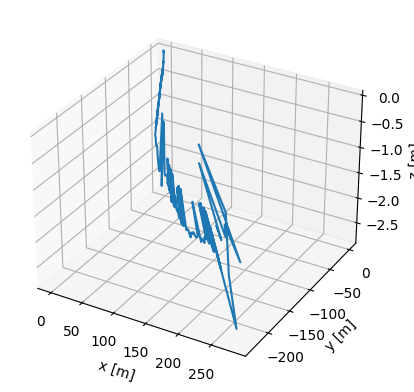

In [82]:
# Plot data
# Extract the x, y, and z coordinates of the points


# plot it
fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = vec_position[:, 0]
ydata = vec_position[:, 1]
zdata = vec_position[:, 2]


ax.plot(xdata[::100], ydata[::100], zdata[::100])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()